# Config

In [15]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*60
presets = "experimental_zeroshot_hpo_hybrid"#'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

drop_night_outliers = True
drop_null_outliers = False

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]

excluded_model_types = ['CAT', 'XGB', 'RF']

use_groups = False
n_groups = 8

# auto_stack = True
num_stack_levels = 0
num_bag_folds = None# 8
num_bag_sets = None#20

use_tune_data = True
use_test_data = False
#tune_and_test_length = 0.5 # 3 months from end
# holdout_frac = None
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False#
sample_weight_estimated = 1
sample_weight_may_july = 1

run_analysis = False

shift_predictions_by_average_of_negatives_then_clip = False
clip_predictions = True
shift_predictions = False

# Loading and preprocessing

In [16]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift all columns with "1h" in them by 1 hour, so that for index 16:00, we have the values from 17:00
    # but only for the columns with "1h" in the name
    #X_shifted = X.filter(regex="\dh").shift(-1, axis=1)
    #print(f"Number of columns with 1h in name: {X_shifted.columns}")


    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_shifted = X[X.index.minute == 0][columns].copy()

    # Create a set for constant-time lookup
    index_set = set(X_shifted.index)

    one_hour = pd.Timedelta('1 hour')

    # print if X_shifted has any gaps in the index
    print(f"X_shifted has gaps in index: {not X_shifted.index.is_monotonic}")

    for row in X_shifted.iterrows():
        if row[0] + one_hour in index_set:
            X_shifted.loc[row[0]] = X_shifted.loc[row[0] + one_hour]


    
    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']


  

    # resample to hourly
    print("index: ", X.index[0])
    X = X.resample('H').mean()
    print("index AFTER: ", X.index[0])

    X[columns] = X_shifted[columns]
    #X[X_old_unshifted.columns] = X_old_unshifted

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    if weight_evaluation:
        # add sample weights, which are 1 for observed and 3 for estimated
        X_train_observed["sample_weight"] = 1
        X_train_estimated["sample_weight"] = sample_weight_estimated
        X_test["sample_weight"] = sample_weight_estimated


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1


    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")

    print(f"Size of estimated after dropping nans: {len(X_train[X_train['is_estimated']==1].dropna(subset=['y']))}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
X_shifted has gaps in index: False
index:  2019-06-02 22:00:00
index AFTER:  2019-06-02 22:00:00
X_shifted has gaps in index: False
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
X_shifted has gaps in index: False
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 0
Size of estimated after dropping nans: 4418
Processing location B...
X_shifted has gaps in index: False
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
X_shifted has gaps in index: False
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
X_shifted has gaps in index: False
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 4
Size of estimated after dropping nans: 3625
Processing location C...
X_shifted has gaps in index: False
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
X_shifted has gaps in index: False
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
X_shifted has g

## Feature enginering

### Remove anomalies

In [17]:
import numpy as np
import pandas as pd


# loop thorugh x train[y], keep track of streaks of same values and replace them with nan if they are too long
# also replace nan with 0

import numpy as np

def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]
            # if location == "B":
            #     continue

            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


# deep copy of X_train into x_copy
X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [18]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9285


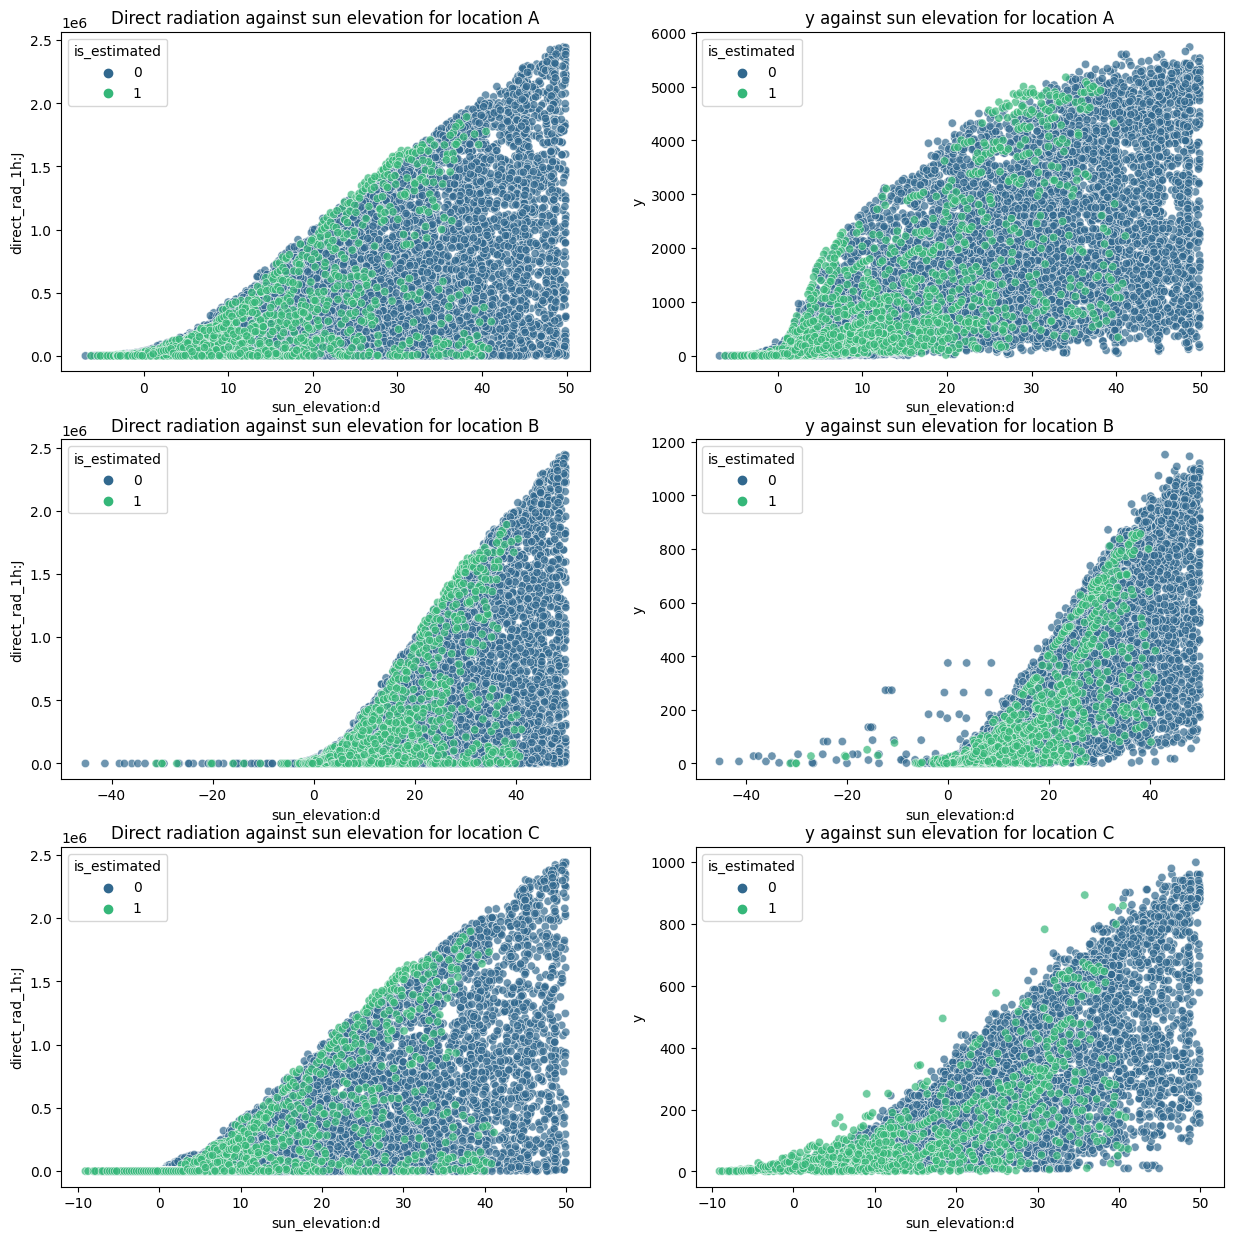

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter out rows where y == 0
temp = X_train[X_train["y"] != 0]

# Plotting
fig, axes = plt.subplots(len(locations), 2, figsize=(15, 5 * len(locations)))

for idx, location in enumerate(locations):
    sns.scatterplot(ax=axes[idx][0], data=temp[temp["location"] == location], x="sun_elevation:d", y="direct_rad_1h:J", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][0].set_title(f"Direct radiation against sun elevation for location {location}")
    
    sns.scatterplot(ax=axes[idx][1], data=temp[temp["location"] == location], x="sun_elevation:d", y="y", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][1].set_title(f"y against sun elevation for location {location}")

# plt.tight_layout()
# plt.show()

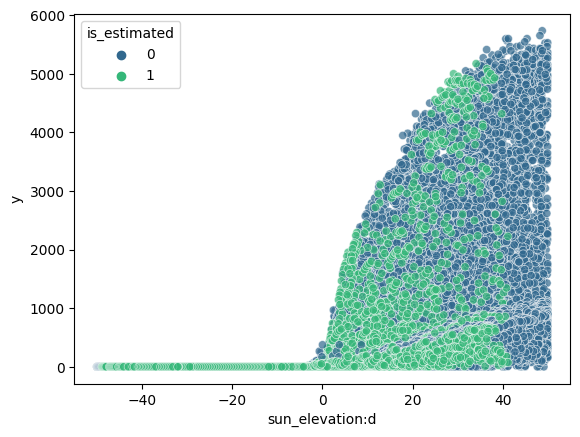

In [20]:
thresh = 0.1

# Update "y" values to NaN if they don't meet the criteria
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)
if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

# Plot using sns scatterplot
sns.scatterplot(data=X_train, x="sun_elevation:d", y="y", hue="is_estimated", palette="viridis", alpha=0.7)
plt.show()


<AxesSubplot: xlabel='sun_elevation:d', ylabel='y'>

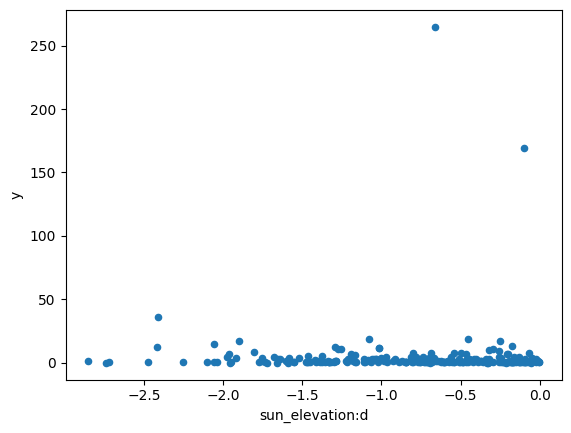

In [21]:
# location B count number of rows with y > 0 and sun_elevation:d < 0

condition = (X_train["location"] == "B") & (X_train["y"] > 0) & (X_train["sun_elevation:d"] < 0)
bad = X_train[condition]

bad.plot.scatter(x="sun_elevation:d", y="y")


Threshold direct: 24458.97
Threshold diffuse: 11822.505000000001
3152


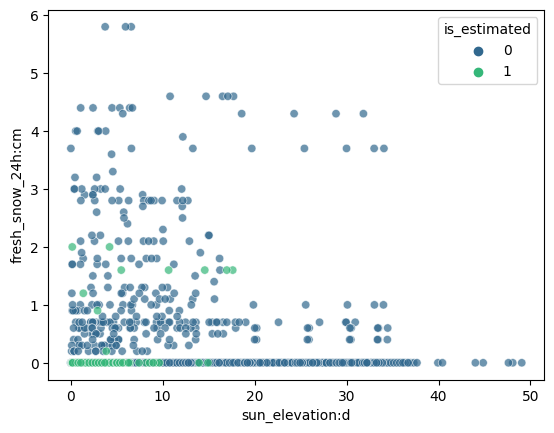

location  is_estimated
A         0                 84
          1                  6
B         0               1459
          1                 51
C         0               1442
          1                110
Name: direct_rad_1h:J, dtype: int64

In [22]:
# set y to nan where y is 0, but direct_rad_1h:J or diffuse_rad_1h:J are > 0 (or some threshold)
threshold_direct = X_train["direct_rad_1h:J"].max() * 0.01
threshold_diffuse = X_train["diffuse_rad_1h:J"].max() * 0.01
print(f"Threshold direct: {threshold_direct}")
print(f"Threshold diffuse: {threshold_diffuse}")

mask = (X_train["y"] == 0) & ((X_train["direct_rad_1h:J"] > threshold_direct) | (X_train["diffuse_rad_1h:J"] > threshold_diffuse)) & (X_train["sun_elevation:d"] > 0) & (X_train["fresh_snow_24h:cm"] < 6) & (X_train[['fresh_snow_12h:cm', 'fresh_snow_1h:cm',  'fresh_snow_3h:cm', 'fresh_snow_6h:cm']].sum(axis=1) == 0)
print(len(X_train[mask]))

#print(X_train[mask][[x for x in X_train.columns if "snow" in x]])

# show plot where mask is true
#sns.scatterplot(data=X_train[mask], x="sun_elevation:d", y="y", hue="is_estimated", palette="viridis", alpha=0.7)
sns.scatterplot(data=X_train[mask], x="sun_elevation:d", y="fresh_snow_24h:cm", hue="is_estimated", palette="viridis", alpha=0.7)
plt.show()

#sns.scatterplot(data=X_train[mask], x="fresh_snow_24h:cm", y="total_cloud_cover:p", hue="is_estimated", palette="viridis", alpha=0.7)



# set y to nan where mask
if drop_null_outliers:
    X_train.loc[mask, "y"] = np.nan

# show how many rows for each location, and for estimated and not estimated
X_train[mask].groupby(["location", "is_estimated"]).count()["direct_rad_1h:J"]


In [23]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  356


### Other stuff

In [24]:
import numpy as np
import pandas as pd

for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

#print(X_train.head())


# If the "sample_weight" column is present and weight_evaluation is True, multiply sample_weight with sample_weight_may_july if the ds is between 05-01 00:00:00 and 07-03 23:00:00, else add sample_weight as a column to X_train
if weight_evaluation:
    if "sample_weight" not in X_train.columns:
        X_train["sample_weight"] = 1

    X_train.loc[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3)), "sample_weight"] *= sample_weight_may_july
        
    
print(X_train.iloc[200])
print(X_train[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3))].head(1))


if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())






X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

absolute_humidity_2m:gm3                7.825
air_density_2m:kgm3                     1.245
ceiling_height_agl:m              2085.774902
clear_sky_energy_1h:J             1685498.875
clear_sky_rad:W                    452.100006
cloud_base_agl:m                  2085.774902
dew_or_rime:idx                           0.0
dew_point_2m:K                     280.549988
diffuse_rad:W                      140.800003
diffuse_rad_1h:J                   538581.625
direct_rad:W                       102.599998
direct_rad_1h:J                   439453.8125
effective_cloud_cover:p             71.849998
elevation:m                               6.0
fresh_snow_12h:cm                         0.0
fresh_snow_1h:cm                          0.0
fresh_snow_24h:cm                         0.0
fresh_snow_3h:cm                          0.0
fresh_snow_6h:cm                          0.0
is_day:idx                                1.0
is_in_shadow:idx                          0.0
msl_pressure:hPa                  

In [25]:
# Create a plot of X_train showing its "y" and color it based on the value of the sample_weight column.
if "sample_weight" in X_train.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.scatterplot(data=X_train, x=X_train.index, y="y", hue="sample_weight", palette="deep", size=3)
    plt.show()

In [26]:

def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

import pandas as pd

def split_and_shuffle_data(input_data, num_bins, frac1):
    """
    Splits the input_data into num_bins and shuffles them, then divides the bins into two datasets based on the given fraction for the first set.

    Args:
        input_data (pd.DataFrame): The data to be split and shuffled.
        num_bins (int): The number of bins to split the data into.
        frac1 (float): The fraction of each bin to go into the first output dataset.

    Returns:
        pd.DataFrame, pd.DataFrame: The two output datasets.
    """
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)

    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [27]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
#split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
# 2022-10-28 22:00:00
split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_set = pd.DataFrame()
tune_set = pd.DataFrame()
new_train_set = pd.DataFrame()

if not use_tune_data:
    raise Exception("Not implemented")
    
for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

    print(f"Size of estimated for location {location}: {len(estimated_set[estimated_set['location'] == location])}. Holdout frac should be % of estimated: {holdout_frac}")

    # shuffle and split data
    loc_tune_set, loc_new_train_set = split_and_shuffle_data(estimated_set[estimated_set['location'] == location], 40, holdout_frac)
    print(f"Length of location tune set : {len(loc_tune_set)}")
    new_train_set = pd.concat([new_train_set, loc_new_train_set])

    if use_test_data:
        loc_test_set, loc_tune_set = split_and_shuffle_data(loc_tune_set, 40, 0.2)
        test_set = pd.concat([test_set, loc_test_set])

    tune_set = pd.concat([tune_set, loc_tune_set])




print("Length of train set before adding test set", len(train_set))
# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
print("Length of train set after adding test set", len(train_set))




if use_groups:
    test_set = test_set.drop(columns=['group'])


tuning_data = tune_set

# number of rows in tuning data for each location
print("Shapes of tuning data", tuning_data.groupby('location').size())


    
if use_test_data:
    test_data = test_set
    print("Shape of test", test_data.shape[0])


train_data = train_set

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
if weight_evaluation:
    # ensure sample weights for data sum to the number of rows in the tuning /train data.
    tuning_data = normalize_sample_weights_per_location(tuning_data)
    train_data = normalize_sample_weights_per_location(train_data)
    if use_test_data:
        test_data = normalize_sample_weights_per_location(test_data)


train_data = TabularDataset(train_data)
tuning_data = TabularDataset(tuning_data)

if use_test_data:
    test_data = TabularDataset(test_data)

Size of estimated for location A: 4358. Holdout frac should be % of estimated: 0.43139054612207434
Length of location tune set : 1856
Size of estimated for location B: 3584. Holdout frac should be % of estimated: 0.5245535714285714
Length of location tune set : 1852
Size of estimated for location C: 2835. Holdout frac should be % of estimated: 0.6631393298059965
Length of location tune set : 1863
Length of train set before adding test set 78668
Length of train set after adding test set 83874
Shapes of tuning data location
A    1493
B    1490
C    1499
dtype: int64
Shape of test 1089


# Quick EDA

In [28]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

In [29]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y", sample=None)

# Modeling

In [30]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 126
Now creating submission number: 127
New filename: submission_127_jorge


In [31]:
predictors = [None, None, None]

In [32]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    # sum of sample weights for this location, and number of rows, for both train and tune data and test data
    if weight_evaluation:
        print("Train data sample weight sum:", train_data[train_data["location"] == loc]["sample_weight"].sum())
        print("Train data number of rows:", train_data[train_data["location"] == loc].shape[0])
        if use_tune_data:
            print("Tune data sample weight sum:", tuning_data[tuning_data["location"] == loc]["sample_weight"].sum())
            print("Tune data number of rows:", tuning_data[tuning_data["location"] == loc].shape[0])
        if use_test_data:
            print("Test data sample weight sum:", test_data[test_data["location"] == loc]["sample_weight"].sum())
            print("Test data number of rows:", test_data[test_data["location"] == loc].shape[0])
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        # sample_weight=sample_weight, 
        # weight_evaluation=weight_evaluation, 
        # groups="group" if use_groups else None,
    ).fit(
        train_data=train_data[train_data["location"] == loc].drop(columns=["ds"]),
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels,
        num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]) if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        # holdout_frac=holdout_frac,
        excluded_model_types=excluded_model_types
    )

    # evaluate on test data
    if use_test_data:
        # drop sample_weight column
        t = test_data[test_data["location"] == loc]#.drop(columns=["sample_weight"])
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/submission_127_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   85.39 GB / 494.38 GB (17.3%)
Train Data Rows:    32008
Train Data Columns: 44
Tuning Data Rows:    1493
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 650.96372, 1179.8265)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter

Training model for location A...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 40 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  1 | ['is_estimated']
	Types of features in processed data (raw dtype, special dtypes):

In [ ]:
import matplotlib.pyplot as plt
leaderboards = [None, None, None]
def leaderboard_for_location(i, loc):
    if use_tune_data:
        plt.scatter(train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"].index, train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"])
        plt.scatter(tuning_data[tuning_data["location"] == loc]["y"].index, tuning_data[tuning_data["location"] == loc]["y"])
        plt.title("Val and Train")
        plt.show()

        if use_test_data:
            lb = predictors[i].leaderboard(test_data[test_data["location"] == loc])
            lb["location"] = loc
            plt.scatter(test_data[test_data["location"] == loc]["y"].index, test_data[test_data["location"] == loc]["y"])
            plt.title("Test")
            
            return lb
    
    return pd.DataFrame()

leaderboards[0] = leaderboard_for_location(0, loc)

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)
leaderboards[1] = leaderboard_for_location(1, loc)

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)
leaderboards[2] = leaderboard_for_location(2, loc)

In [ ]:
# save leaderboards to csv
pd.concat(leaderboards).to_csv(f"leaderboards/{new_filename}.csv")


for i in range(len(predictors)):
    print(f"Predictor {i}:")
    print(predictors[i].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])
#test_data

In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    #train_data.loc[train_data["location"] == loc, "prediction"] =  predictors[i].predict(train_data[train_data["location"] == loc])
    if use_tune_data:
        tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        test_data.loc[test_data["location"] == loc, "prediction"] =  predictors[i].predict(test_data[test_data["location"] == loc])  

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    if use_tune_data:
        tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    #train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")
    #train_data[train_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions train")
    if use_tune_data:
        tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())

# Instead of clipping, shift all prediction values up by the largest negative number.
# This way, the smallest prediction will be 0.
elif shift_predictions:
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred["prediction"] = pred["prediction"] - pred["prediction"].min()
        print("Smallest prediction after clipping:", pred["prediction"].min())

elif shift_predictions_by_average_of_negatives_then_clip:
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        mean_negative = pred[pred["prediction"] < 0]["prediction"].mean()
        # if not nan
        if mean_negative == mean_negative:
            pred["prediction"] = pred["prediction"] - mean_negative

        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())



# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

In [ ]:
# feature importance
# print starting calculating feature importance for location A with big text font
print("\033[1m" + "Calculating feature importance for location A..." + "\033[0m")
predictors[0].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "A"], time_limit=60*10)
print("\033[1m" + "Calculating feature importance for location B..." + "\033[0m")
predictors[1].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "B"], time_limit=60*10)
print("\033[1m" + "Calculating feature importance for location C..." + "\033[0m")
predictors[2].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "C"], time_limit=60*10)

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
#subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_automatic_save.pdf"), "autogluon_each_location.ipynb"])
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])